<a href="https://colab.research.google.com/github/joshua-meppiel/dl-workshop-2022/blob/main/Build_a_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPSCI 5390 - Semester Project - Task 1

The objective in this task is to design a convolutional neural network (not feed-forward neural network) to overfit your dataset.

This task uses the same model architecture as the Subtask 1, but without supplying the ground truth (output labels) as part of the model input. 


Note: For the subtask in which ground truths are provided to the model during training, please see the file named `Task 1 output labels.ipynb`

# Imports and copy data

Import the various libraries used throughout the notebook and set the training and test data directories.

In [1]:
import numpy as np, pathlib, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

data_dir = pathlib.Path('/home/josh/data/asl/train')
test_data_dir = pathlib.Path('/home/josh/data/asl/test/')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

image_count = len(list(test_data_dir.glob('*/*.jpg')))
print(image_count)

2023-04-17 22:43:28.788641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 22:43:29.735143: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


87000
29


# Check versions and devices

Output the TensorFlow and Numpy versions along with the number of CPU's and number of GPU's available.  I do this as I am running the notebook inside of Ubuntu on WSL, not in the cloud.  I've had issues with certain versions of TensoFlow and Numpy, particularly around data augmentation.

In [2]:
print(f"TensorFlow version: ", tf.__version__)
print(f"Numpy version: ", np.__version__)

print(f"Available CPU(s): ", len(tf.config.list_physical_devices('CPU')))
print(f"Available GPU(s): ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.12.0
Numpy version:  1.23.5
Available CPU(s):  1
Available GPU(s):  1


2023-04-17 22:43:31.696796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-17 22:43:31.788219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-17 22:43:31.788273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.


# Load data into traning and validation sets

Create the datasets using the Keras `image_dataset_from_directory` utility.  This utility is useful when the dataset is too large to fit into the GPU's memory.  It will load one batch at a time into memory and has automatic caching mechanisms to improve performance.  At the end we print the class names and the number of classes.

In this Task 1, we do not supply the ground truths as an input; however, we also do not split the dataset into a separate training and validation(nor test) datasets.  All data is supplied to the network as both training and validation.

In [3]:
batch_size = 48
#img_height = 256
#img_width = 256

# Changed to 224 x 224 for the "top" of ResNet50
img_height = 224
img_width = 224


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


2023-04-17 22:43:35.548286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-17 22:43:35.548368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-17 22:43:35.548401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-17 22:43:36.375176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-17 22:43:36.375249: I tensorflow/compile

Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
29


# Test display images

This selects 9 images from the dataset and displays them along with their labels.  This is for verification purposes only to ensure that the dataset is loading images as expected.



2023-04-17 22:43:39.397506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [69600]
	 [[{{node Placeholder/_4}}]]
2023-04-17 22:43:39.397848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [69600]
	 [[{{node Placeholder/_4}}]]


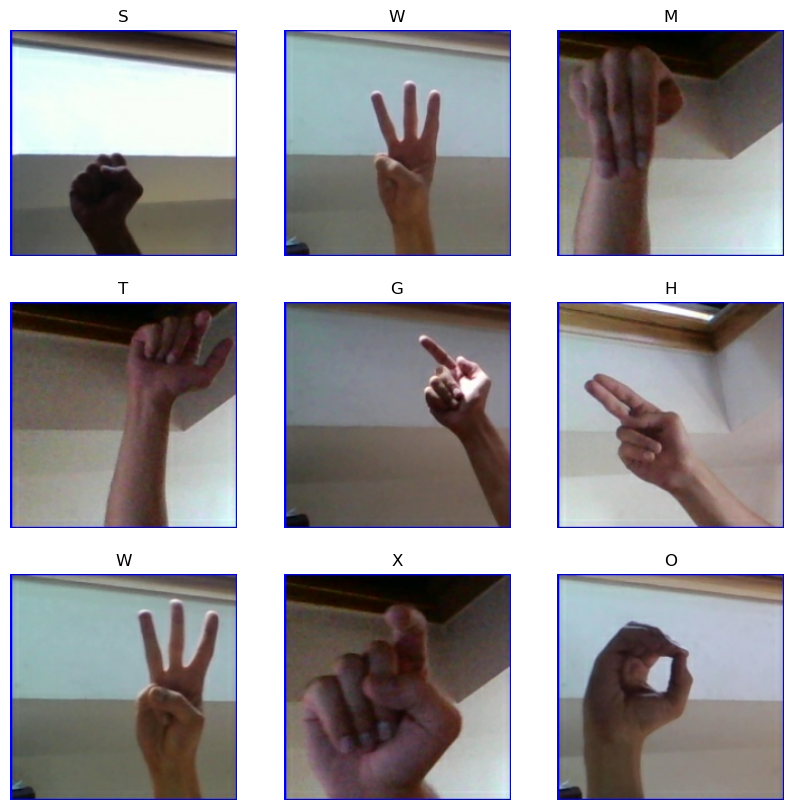

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Create the model

This creates the model.  This is the same architecture as Subtask 1.

In [5]:
"""
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(width_factor=0.1,height_factor=0.1)
  ]
)

inputs = tf.keras.Input(shape=(256, 256, 3))

#data_augmentation = tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3))(inputs)
#data_augmentation = tf.keras.layers.RandomRotation(0.1)(inputs)
#data_augmentation = tf.keras.layers.RandomZoom(0.1)(data_augmentation)
data_augmentation = tf.keras.layers.RandomTranslation(width_factor=0.1,height_factor=0.1)(inputs)


x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(data_augmentation)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(42, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
"""

'\ndata_augmentation = tf.keras.Sequential(\n  [\n    layers.RandomFlip("horizontal",\n                      input_shape=(img_height,\n                                  img_width,\n                                  3)),\n    layers.RandomRotation(0.1),\n    layers.RandomZoom(0.1),\n    layers.RandomTranslation(width_factor=0.1,height_factor=0.1)\n  ]\n)\n\ninputs = tf.keras.Input(shape=(256, 256, 3))\n\n#data_augmentation = tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3))(inputs)\n#data_augmentation = tf.keras.layers.RandomRotation(0.1)(inputs)\n#data_augmentation = tf.keras.layers.RandomZoom(0.1)(data_augmentation)\ndata_augmentation = tf.keras.layers.RandomTranslation(width_factor=0.1,height_factor=0.1)(inputs)\n\n\nx = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation=\'relu\')(data_augmentation)\nx = tf.keras.layers.MaxPooling2D((2, 2))(x)\nx = tf.keras.layers.BatchNormalization()(x)\n\nx = tf.keras.layers.Conv2D(filters=16, kernel_size=3,

In [6]:

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import MobileNetV2

"""
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
model = MobileNetV2(include_top=False, weights='imagenet')(inputs)
model.trainable = False
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(num_classes, activation='softmax')(model)
"""

"""
#inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x  = ResNet50(input_shape=(img_height, img_width, 3))
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=(img_height, img_width, 3), outputs=outputs, name="my_model")
print(type(model))
"""

base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)

#base_model = tf.keras.applications.Xception(
    #weights='imagenet',
    #input_shape=(150, 150, 3),
    #include_top=False)  


base_model.trainable = False


inputs = tf.keras.Input(shape=(224, 224, 3))

x = tf.keras.applications.xception.preprocess_input(inputs)

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Create Callbacks

Here I create a custom callback function.  This function monitors the training accuracy, when it reaches 100% it stops the training early.

In [7]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True

callback=MyThresholdCallback(threshold=1.0)

# Compile the Model

Here we set the optimizer and compile the model.  We then print the sumamry of the model.

In [8]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                             

# Display the model structure

Display a graphical representation of the model structure.

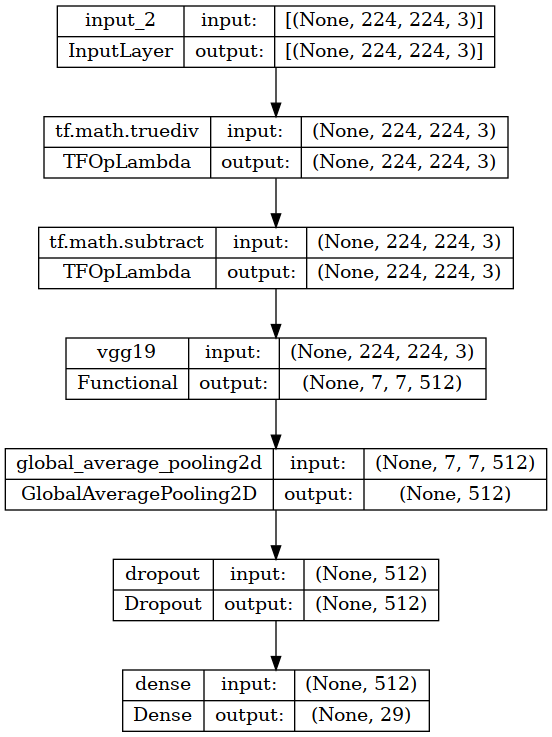

In [9]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

# Train the model

Here we train the model.  Note that here we are supplying the training data for both the training and validation sets to the `fit()` function.

In [10]:
history = model.fit(train_ds, epochs=8, validation_data=train_ds)

Epoch 1/8


2023-04-17 22:43:40.932706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [69600]
	 [[{{node Placeholder/_4}}]]
2023-04-17 22:43:40.932916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [69600]
	 [[{{node Placeholder/_4}}]]
2023-04-17 22:43:42.702468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-17 22:43:45.078036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-17 

   1/1450 [..............................] - ETA: 1:47:03 - loss: 3.5185 - accuracy: 0.0000e+00

2023-04-17 22:43:45.287283: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1450/1450 [==============================] - 367s 251ms/step - loss: 2.2935 - accuracy: 0.5647 - val_loss: 1.5457 - val_accuracy: 0.8312
Epoch 2/8
1450/1450 [==============================] - 361s 249ms/step - loss: 1.2813 - accuracy: 0.8105 - val_loss: 0.9792 - val_accuracy: 0.8872
Epoch 3/8
1450/1450 [==============================] - 365s 252ms/step - loss: 0.9147 - accuracy: 0.8539 - val_loss: 0.7129 - val_accuracy: 0.9171
Epoch 4/8
1450/1450 [==============================] - 353s 244ms/step - loss: 0.7220 - accuracy: 0.8754 - val_loss: 0.5616 - val_accuracy: 0.9310
Epoch 5/8
1450/1450 [==============================] - 368s 254ms/step - loss: 0.6048 - accuracy: 0.8892 - val_loss: 0.4653 - val_accuracy: 0.9399
Epoch 6/8
1450/1450 [==============================] - 368s 254ms/step - loss: 0.5264 - accuracy: 0.8984 - val_loss: 0.3973 - val_accuracy: 0.9474
Epoch 7/8
1450/1450 [==============================] - 368s 254ms/step - loss: 0.4694 - accuracy: 0.9062 - val_loss: 0.3488 - va

# Investigate Learning 

Plot the training and loss statistics for the training of the model.

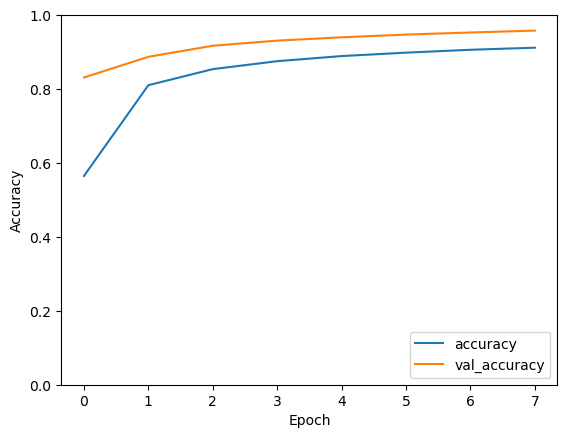

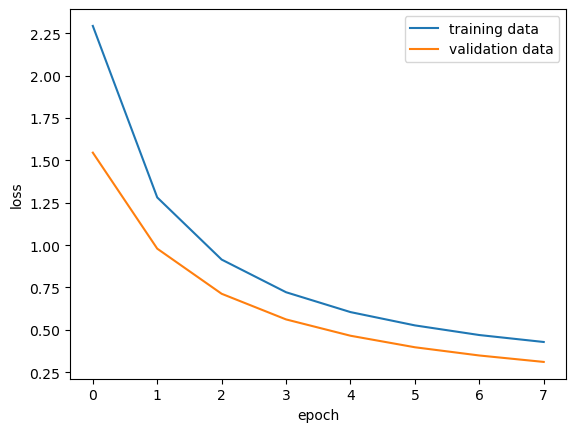

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.figure()
plt.plot(history.history['loss']) # replace with accuracy/MAE
plt.plot(history.history['val_loss']) # replace with val_accuracy, etc.
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='upper right')

plt.show()

# Validation Data Set

Evaluate the model.

In [12]:
valid_loss, valid_acc = model.evaluate(valid_ds, verbose=2)

2023-04-17 23:32:14.864248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [17400]
	 [[{{node Placeholder/_4}}]]
2023-04-17 23:32:14.864684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [17400]
	 [[{{node Placeholder/_0}}]]


363/363 - 45s - loss: 0.3219 - accuracy: 0.9559 - 45s/epoch - 124ms/step


# Make Predictions and Evaluate the Model on Test Data

Create the test dataset.  Evaluate the model on this test dataset.  Note that on this Task 1 the accuracy is very low when evaluatiing the model using the test dataset.

Plot all 29 images along with their ground truth labels(left side of colon) and predicted labels(right side of colon).

Found 29 files belonging to 29 classes.


2023-04-17 23:33:00.037952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29]
	 [[{{node Placeholder/_4}}]]
2023-04-17 23:33:00.038118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29]
	 [[{{node Placeholder/_4}}]]


1/1 - 1s - loss: 0.1383 - accuracy: 1.0000 - 701ms/epoch - 701ms/step


2023-04-17 23:33:00.741622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29]
	 [[{{node Placeholder/_4}}]]
2023-04-17 23:33:00.741808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29]
	 [[{{node Placeholder/_4}}]]


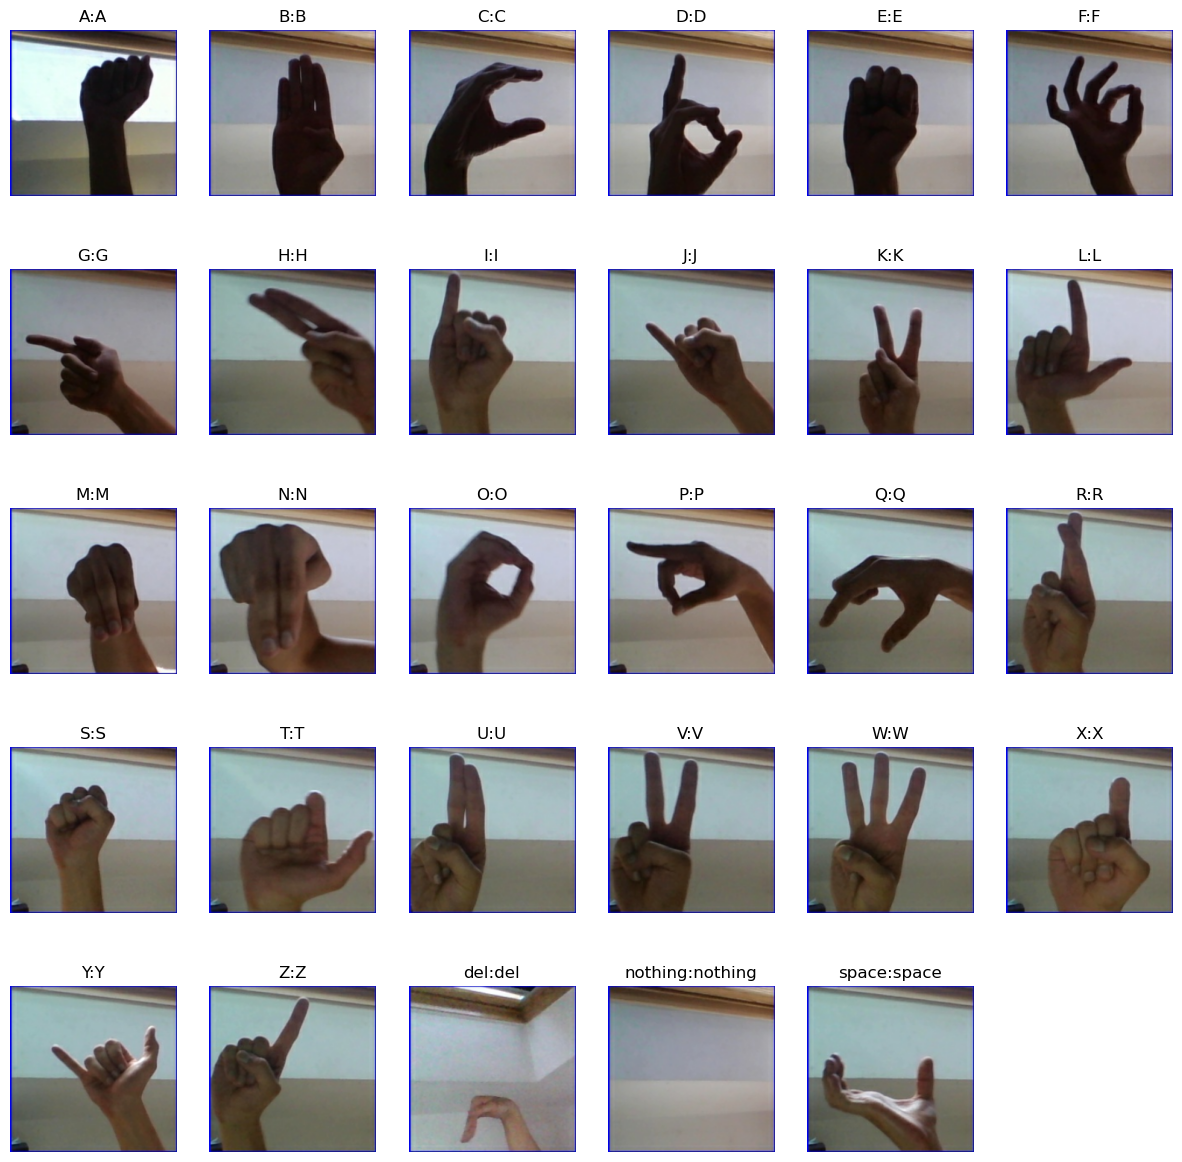

In [13]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  validation_split=None,
  subset=None,
  seed=None,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False
)

test_loss, test_acc = model.evaluate(test_ds, verbose=2)
test_class_names = test_ds.class_names
test_ds_instance = test_ds.take(1)

plt.figure(figsize=(15, 15))
for images, labels in test_ds_instance:
  for i in range(29):
    x = np.expand_dims(images[i], axis=0)
    p = model.predict(x, verbose=0)    
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]] + ":" + class_names[p.argmax()])
    plt.axis("off")